# DATA

## What is this notebook about

This notebook builds upon the notebook ``` spacenet6_masking.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget. 



This notebook shall be used for resizing all image input format. The available input formats will be
* PAN
* PS-RGB
* PS-RGBNIR
* RGBNIR
* SAR-Intensity

After resizing, these images will be saved to reduce the need for further processing. They will be saved in their original channel format, as a .tif file. The resized images will be read in and fed to a unet model to identify buildings. 

Functions to support data generation from all five image modes will be made available to easily generate the needed data

**Output geo label**

with the predicted mask made from our model, we try and transform it back into a geotiff file, so that we can do proper iou analysis

**Solaris is a bottleneck on colab**

Can't get solaris to install, this is a bust. Need to find another way to get the labelling done 

## Setup COLAB and imports

Mount drive to gain access to files

In [ ]:
''' Used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Installations required

In [ ]:
! pip install rasterio
! pip install keras_unet
! pip install focal-loss
! pip install segmentation-models

     |████████████████████████████████| 18.2MB 1.2MB/s 


Imports required

In [ ]:
''' dealing with .tif files '''
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' core '''
import numpy as np
import pandas as pd

''' utilities '''
from tqdm import tqdm
import copy
import datetime

''' image processing '''
import tensorflow as tf
from tensorflow.keras.preprocessing import image

''' unet model '''
from keras import backend as K
from focal_loss import BinaryFocalLoss
from keras_unet.models import satellite_unet

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import JaccardLoss, BinaryFocalLoss
from segmentation_models.metrics import IOUScore, FScore

Using TensorFlow backend.


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `keras` framework.


## Global

Constants and lookups - For reference the various image types are as such (amax is a rough gauge):

```
type             shape                dtype       gauge of max value    gauge of min value
PAN              (1, 900, 900)        uint16      1844                  0
PS-RGB           (3, 900, 900)        uint8       255                   0
PS-RGBNIR        (4, 900, 900)        uint16      2047                  0
RGBNIR           (4, 450, 450)        uint16      2047                  0
SAR-Intensity    (4, 900, 900)        float32     82.70110321044922     0.0
```



In [ ]:
''' get the same sequence for random set every time '''
seed = 42
np.random.seed = seed
tf.seed = seed       

''' lookup - define image channels for each image type '''
IMG_TYPE_LOOKUP = {
    'PAN': {'channels': 1, 'dtype': np.uint16}, 
    'PS-RGB': {'channels': 3, 'dtype': np.uint8}, 
    'PS-RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'SAR-Intensity': {'channels': 4, 'dtype': np.float32}, 
}

We will be setting the amount of data that we want to use for train/test
* There are 3401 images for each image type
* The actual spacenet6 "test folder" has only uneseen SAR-Intensity data

Therefore for training purposes, we will pull out our own "test data" from the training set for ease of verifying output 

Random indexes will be used for training and test

In [ ]:
''' set the various sizes we want to use '''
SIZE_ALL = 3401 
SIZE_TRAIN = 800           # CHANGE HERE
SIZE_TEST = 80            # CHANGE HERE


''' Generate the indexes that we will be using for train and test '''
ALL_IDX = np.arange(SIZE_ALL)

TRAIN_IDX = np.random.choice(ALL_IDX, SIZE_TRAIN, replace=False)
TRAIN_IDX.sort()

ALL_IDX_2 = np.setdiff1d(ALL_IDX, TRAIN_IDX)

TEST_IDX = np.random.choice(ALL_IDX_2, SIZE_TEST, replace=False)
TEST_IDX.sort()

## Helper functions

Available functions:
* ``` plot_XY(plotname: str, X: np.dtype[SIZE], Y: np.bool[SIZE], X_name: str, Y_name: str) : None ```
* ``` plot_XY_preds(plotname: str, X: np.dtype[SIZE], Y: np.bool[SIZE], P: np.bool[SIZE], X_name: str, Y_name: str, P_name: str) : None ```
* ``` recall_m(y_true, y_pred) : None ```
* ``` precision_m(y_true, y_pred) : None ```
* ``` f1_m(y_true, y_pred) : None ```

Various plotting functions

In [ ]:
def plot_XY(plotname, X, Y, X_name, Y_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  plt.show()

In [ ]:
def plot_XY_preds(plotname, X, Y, P, X_name, Y_name, P_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()

In [ ]:
def plot_history(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  ax1.plot(history['loss'], label='train')
  ax1.plot(history['val_loss'], label='val')
  ax1.title.set_text('loss')
  ax1.legend()

  ax2.plot(history['iou_score'], label='train')
  ax2.plot(history['val_iou_score'], label='val')
  ax2.title.set_text('iou_score')
  ax2.legend()

  ax3.plot(history['f1-score'], label='train')
  ax3.plot(history['val_f1-score'], label='val')
  ax3.title.set_text('f1-score')
  ax3.legend()

Define metrics for the unet models

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Create a csv file to store metrics history

In [ ]:
PATH_METRICS = '/content/gdrive/My Drive/Colab Notebooks/spacenet6/metrics_keras_8_9_10.csv'

# TIMESTAMP = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION = 'trial', 'trial', 'trial', 'trial'
# SIZE_TRAIN, SIZE_TEST, train_loss, train_iou_score, train_f1_score, val_loss, val_iou_score, val_f1_score, test_loss, test_iou_score, test_f1_score = 0,0,0,0,0,0,0,0,0,0,0

# METRICS_HISTORY = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, 
#                              train_loss, train_iou_score, train_f1_score, 
#                              val_loss, val_iou_score, val_f1_score, 
#                              test_loss, test_iou_score, test_f1_score
#                              ]]),
#                    columns=['timestamp', 'img_type', 'model_type', 'pretrain', 'loss_function', 'size_train', 'size_test', 
#                             'train_loss', 'train_iou_score', 'train_f1-score', 
#                             'val_loss', 'val_iou_score', 'val_f1-score', 
#                             'test_loss', 'test_iou_score', 'test_f1-score'
#                             ],
#                   )
# METRICS_HISTORY.to_csv(PATH_METRICS, index=False)



In [ ]:
def store_metrics(train_loss, train_iou_score, train_f1_score, val_loss, val_iou_score, val_f1_score, test_loss, test_iou_score, test_f1_score, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS):
  TIMESTAMP = datetime.datetime.now().strftime("%m/%d/%Y %H:%M:%S")

  ''' create another df that looks just like that and concat with ''' 
  new_metrics = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, 
                             train_loss, train_iou_score, train_f1_score, 
                             val_loss, val_iou_score, val_f1_score, 
                             test_loss, test_iou_score, test_f1_score
                             ]]),
                   columns=['timestamp', 'img_type', 'model_type', 'pretrain', 'loss_function', 'size_train', 'size_test', 
                            'train_loss', 'train_iou_score', 'train_f1-score', 
                            'val_loss', 'val_iou_score', 'val_f1-score', 
                            'test_loss', 'test_iou_score', 'test_f1-score'
                            ],
                  )
  
  METRICS_HISTORY = pd.read_csv(PATH_METRICS)
  METRICS_HISTORY = pd.concat([new_metrics, METRICS_HISTORY])
  METRICS_HISTORY.to_csv(PATH_METRICS, index=False)
  print("saved model metrics")


## Generator

Available generators: 

* ``` gen_input_image_details(IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP) : (IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_CHANNELS: int64, IMG_DTYPE_SRC: np.dtype, IMG_DTYPE: np.uint8) ```

* ``` gen_paths(IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64) : (PATH_SRC: PosixPath, PATH_SRC_IMAGE: PosixPath, PATH_SRC_MASK: PosixPath, PATH_DATA: PosixPath, PATH_IMAGE: PosixPath, PATH_MASK: PosixPath) ```

* ``` gen_resized_images(PATH_SRC_IMAGE: PosixPath, PATH_SRC_MASK: PosixPath, PATH_IMAGE: PosixPath, PATH_MASK: PosixPath, IMG_HEIGHT: int64, IMG_WIDTH: int64) : None ```

* ``` gen_train_test_set(PATH_IMAGE: PosixPath, PATH_MASK: PosixPath, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_CHANNELS: int64, IMG_DTYPE_SRC: np.dtype, TRAIN_IDX: int64[SIZE_TRAIN], TEST_IDX: int64[SIZE_TEST]) : (X_train: np.dtype[SIZE_TRAIN], Y_train: np.bool[SIZE_TRAIN], X_test: np.dtype[SIZE_TEST], Y_test: np.bool[SIZE_TEST]) ```

Reading several papers has indicated that 256x256 size is a good size for the model, hence we shall use it as the image size for now. We will set the output specifications here

In [ ]:
def gen_input_image_details(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP):
  IMG_CHANNELS = IMG_TYPE_LOOKUP[IMG_TYPE]['channels']
  IMG_DTYPE_SRC = IMG_TYPE_LOOKUP[IMG_TYPE]['dtype']
  IMG_DTYPE = np.uint8               

  return (IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE)

Setting the paths that we require, which will change based on the image type and image size specified

In [ ]:
def gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH):
  ''' set the original data source folder '''
  PATH_SRC = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam')
  PATH_SRC_IMAGE = PATH_SRC/IMG_TYPE
  PATH_SRC_MASK = PATH_SRC/'_mask'


  ''' change in accordance to the image type and dimensions '''
  COMBI = IMG_TYPE + '_' + str(IMG_HEIGHT) + 'x' + str(IMG_WIDTH)


  ''' set the directories for this combination '''
  PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
  PATH_DATA.mkdir(parents=True, exist_ok=True)

  PATH_IMAGE = PATH_DATA/'image'
  PATH_IMAGE.mkdir(parents=True, exist_ok=True)

  PATH_MASK = PATH_DATA/'mask'
  PATH_MASK.mkdir(parents=True, exist_ok=True)

  return (PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK)

This will check if the required resized images have already been created. If not, it will create it.

In [ ]:
def gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH):
  def resize_and_save(img_src_path, img_fname, img_save_path):
    img = rasterio.open(img_src_path/img_fname)

    ''' use the metadata from the original image '''
    transform = img.transform
    meta = img.meta.copy()

    ''' resize the image '''
    resized_img = img.read()
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))
    resized_img = reshape_as_image(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = tf.image.resize(resized_img, [IMG_HEIGHT, IMG_WIDTH], method='nearest', preserve_aspect_ratio=True, antialias=True)
    resized_img = reshape_as_raster(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    ''' update metadata with new size '''
    meta.update({"transform": transform,
                "height": resized_img.shape[1],
                "width": resized_img.shape[2]
                })

    ''' write the resized image to a new geotiff '''
    with rasterio.open(img_save_path/img_fname, 'w', **meta) as dst:
      dst.write(resized_img)




  ''' Verify contents in source directory are present and assign to iterator '''
  src_image_ids = next(os.walk(PATH_SRC_IMAGE))[2]
  src_image_ids.sort()
  # print('len(src_image_ids): {}'.format(len(src_image_ids)))
  # print(src_image_ids[:3])

  src_mask_ids = next(os.walk(PATH_SRC_MASK))[2]
  src_mask_ids.sort()
  # print('len(src_mask_ids): {}'.format(len(src_mask_ids)))
  # print(src_mask_ids[:3])


  ''' check the target directory for existing files '''
  existing_image_ids = next(os.walk(PATH_IMAGE))[2]
  existing_image_ids.sort()
  # print('len(existing_image_ids): {}'.format(len(existing_image_ids)))
  # print(existing_image_ids[:3])

  existing_mask_ids = next(os.walk(PATH_MASK))[2]
  existing_mask_ids.sort()
  # print('len(existing_mask_ids): {}'.format(len(existing_mask_ids)))
  # print(existing_mask_ids[:3])


  ''' check if resized files already exist, else create them '''
  if (existing_image_ids == src_image_ids) and (existing_mask_ids == src_mask_ids): 
    print('Resized images and masks available')
    pass
  else:
    # print('Resizing image')
    for n, id in tqdm(enumerate(src_image_ids), total=len(src_image_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_IMAGE, id, PATH_IMAGE)
    # print('Finished resizing image')

    # print('Resizing mask')
    for n, id in tqdm(enumerate(src_mask_ids), total=len(src_mask_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_MASK, id, PATH_MASK)
    # print('Finished resizing mask')

    print('Resized images and masks generated')

This will return the train test set 

In [ ]:
def gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX):
  ''' get the ids/filenames that we need, based on the random index allocation to avoid grouping '''
  ''' X are image files, Y are mask files '''
  all_img_ids = next(os.walk(PATH_IMAGE))[2]
  all_img_ids.sort()
  all_img_ids = np.array(all_img_ids)

  all_mask_ids = next(os.walk(PATH_MASK))[2]
  all_mask_ids.sort()
  all_mask_ids = np.array(all_mask_ids)

  X_train_ids = all_img_ids[TRAIN_IDX]
  X_train_ids.sort()
  Y_train_ids = all_mask_ids[TRAIN_IDX]
  Y_train_ids.sort()

  X_test_ids = all_img_ids[TEST_IDX]
  X_test_ids.sort()
  Y_test_ids = all_mask_ids[TEST_IDX]
  Y_test_ids.sort()

  # print(len(all_img_ids))
  # print(all_img_ids[:3])
  # print(len(all_mask_ids))
  # print(all_mask_ids[:3])
  # print(len(X_train_ids))
  # print(X_train_ids[:3])
  # print(len(Y_train_ids))
  # print(Y_train_ids[:3])
  # print(len(X_test_ids))
  # print(X_test_ids[:3])
  # print(len(Y_test_ids))
  # print(Y_test_ids[:3])


  ''' prepare numpy arrays to store converted image and mask files. Image files will need to be converted to IMG_DTYPE_SRC and mask files will be converted to np.bool '''
  X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
  Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
  Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

  # print('X_train', X_train.shape, X_train.dtype)
  # print('Y_train', Y_train.shape, Y_train.dtype)
  # print('X_test', X_test.shape, X_test.dtype)
  # print('Y_test', Y_test.shape, Y_test.dtype)

  ''' actually format the imaegs into the correct data shape and type '''
  print('formatting training images')
  for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
    img = rasterio.open(PATH_IMAGE/id).read()
    img = reshape_as_image(img)
    X_train[n] = img
  print('Finished formatting training images')

  print('formatting training masks')
  for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
    img = rasterio.open(PATH_MASK/id).read()
    img = reshape_as_image(img)
    img = img.astype(np.bool) 
    Y_train[n] = img
  print('Finished formatting training masks')

  print('formatting test images')
  for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
    img = rasterio.open(PATH_IMAGE/id).read()
    img = reshape_as_image(img)
    X_test[n] = img
  print('Finished formatting test images')

  print('formatting test masks')
  for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
    img = rasterio.open(PATH_MASK/id).read()
    img = reshape_as_image(img)
    img = img.astype(np.bool) 
    Y_test[n] = img
  print('Finished formatting test masks')  


  return (X_train, Y_train, X_test, Y_test)

This will modify the SAR data to something that can be accepted by the unet without crashing

In [ ]:
def gen_modified_sar(X_train_sar, X_test_sar, SIZE_TRAIN, SIZE_TEST):
  ''' Convert the float32 to uint8 '''
  if np.amax(X_train_sar) > np.amax(X_test_sar):
    sar_max = np.amax(X_train_sar)
  else:
    sar_max = np.amax(X_test_sar)

  X_train_sar *= 255.0/sar_max
  X_test_sar *= 255.0/sar_max

  X_train_sar = X_train_sar.astype(np.uint8)
  X_test_sar = X_test_sar.astype(np.uint8)

  return (X_train_sar, X_test_sar)

In [ ]:
def gen_basic_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, X_train, Y_train, MODEL_VAL_SPLIT, MODEL_BATCH_SIZE, MODEL_EPOCHS, PATH_DATA, MODEL_NAME):
  model = satellite_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  model.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)
  # model.summary()

  checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

  callbacks = [
          tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
          tf.keras.callbacks.TensorBoard(log_dir='logs')
        ]   

  results = model.fit(X_train, Y_train, validation_split=MODEL_VAL_SPLIT, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, callbacks=callbacks)        

  # model.save(PATH_DATA/MODEL_NAME)  

  return (model, results)

In [ ]:
def gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS):
  ''' split train, val 90-10. validation_split takes the percentage from the back '''
  preds_train = model.predict(X_train[:MODEL_VAL_OFFSET], verbose=1)
  preds_val = model.predict(X_train[MODEL_VAL_OFFSET:], verbose=1)
  preds_test = model.predict(X_test, verbose=1)

  preds_train_t = (preds_train > 0.5).astype(np.uint8)
  preds_val_t = (preds_val > 0.5).astype(np.uint8)
  preds_test_t = (preds_test > 0.5).astype(np.uint8)


  ''' evaluation of prediction '''
  metric_names = model.metrics_names
  
  print("train set evaluation")
  train_metrics = model.evaluate(X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', train_metrics[x])

  print("\nvalidation set evaluation")
  val_metrics = model.evaluate(X_train[MODEL_VAL_OFFSET:], X_train[MODEL_VAL_OFFSET:])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', val_metrics[x])

  print("\ntest set evaluation")
  test_metrics = model.evaluate(X_test, Y_test)
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', test_metrics[x])

  store_metrics(train_metrics[0], train_metrics[1], train_metrics[2], val_metrics[0], val_metrics[1], val_metrics[2], test_metrics[0], test_metrics[1], test_metrics[2], IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

  return (preds_train_t, preds_val_t, preds_test_t)

# Get output

We shall try learning on the PS-RGBNIR first by loading in the weights, then passing the weights to the SAR data and see how that works

## Reconstruct PS-RGBNIR

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 20

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model_transfer_psrgbnir = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4), encoder_freeze=True)

model_transfer_psrgbnir.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

model_transfer_psrgbnir.load_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

# results = model_transfer_psrgbnir.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model_transfer_psrgbnir.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model_transfer_psrgbnir.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model_transfer_psrgbnir, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 25s 314ms/step
train set evaluation
720/720 [==============================] - 229s 317ms/step
loss :  0.347333734565311
iou_score :  0.6532230973243713
f1-score :  0.7899227738380432

validation set evaluation
80/80 [==============================] - 25s 317ms/step
loss :  0.849262285232544
iou_score :  0.1607116311788559
f1-score :  0.27468040585517883

test set evaluation
80/80 [==============================] - 25s 314ms/step
loss :  0.384737491607666
iou_score :  0.6215509176254272
f1-score :  0.7662427425384521
saved model metrics


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 179
train preds  set


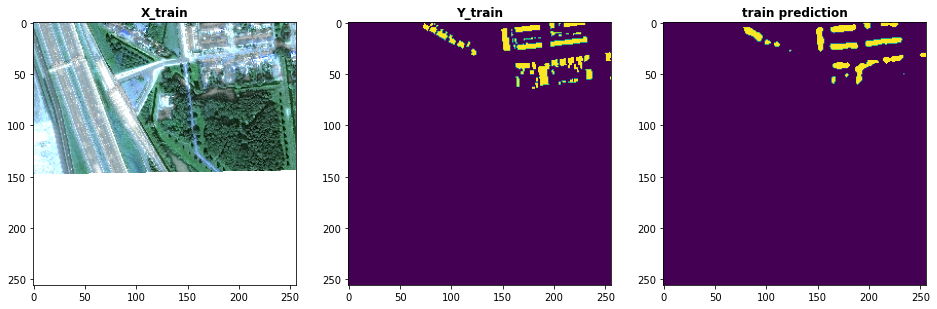

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 69
val preds  set


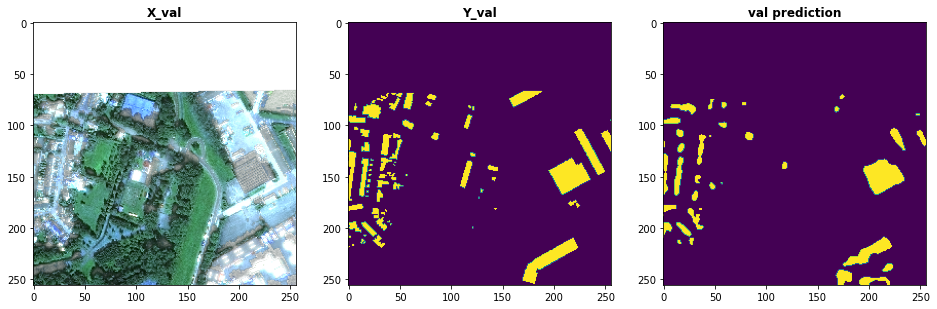

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 69
test preds  set


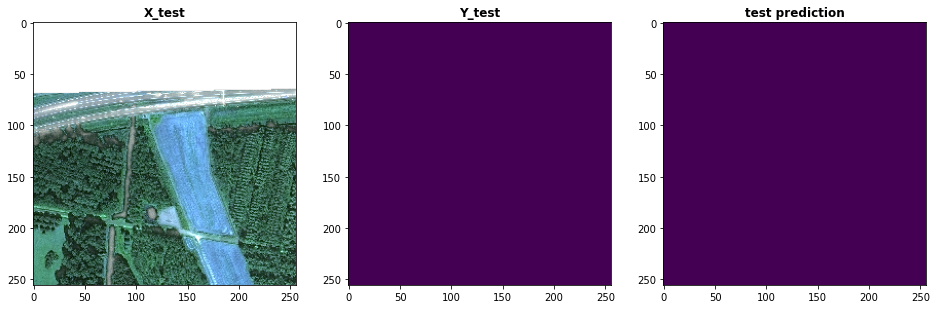

NameError: ignored

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

## Reconstruct SAR


We utilise the previous model that was trained on PSRGBNIR images and try and transfer the model weights into the SAR model

Both models are trained on efficientnetb0, it is far easier to transfer weights using the same backbone versus using different ones. But experimentation can be done to try and mix models - PSRGBNIR performs better on the vgg16 backbone

In [ ]:
''' Assumes we already have a sample data generated, else need to create the np arrays and save  '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 20

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model_transfer_sar = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4), encoder_freeze=True)

model_transfer_sar.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

model_transfer_sar.load_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

# results = model_transfer_sar.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model_transfer_sar.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model_transfer_sar.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))



/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model_transfer_sar, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 25s 314ms/step
train set evaluation
720/720 [==============================] - 227s 315ms/step
loss :  0.6053137607044644
iou_score :  0.39633071422576904
f1-score :  0.5655712485313416

validation set evaluation
80/80 [==============================] - 25s 314ms/step
loss :  0.9043034911155701
iou_score :  0.09786081314086914
f1-score :  0.17742763459682465

test set evaluation
80/80 [==============================] - 25s 310ms/step
loss :  0.7421290636062622
iou_score :  0.24448184669017792
f1-score :  0.3904768228530884
saved model metrics


index: 678
train preds  set


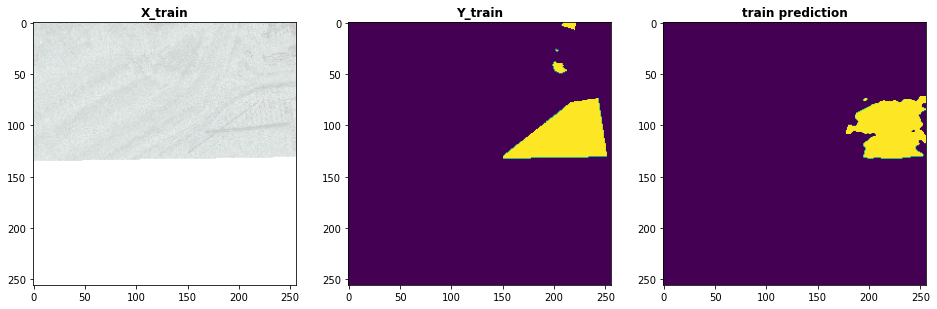

index: 6
val preds  set


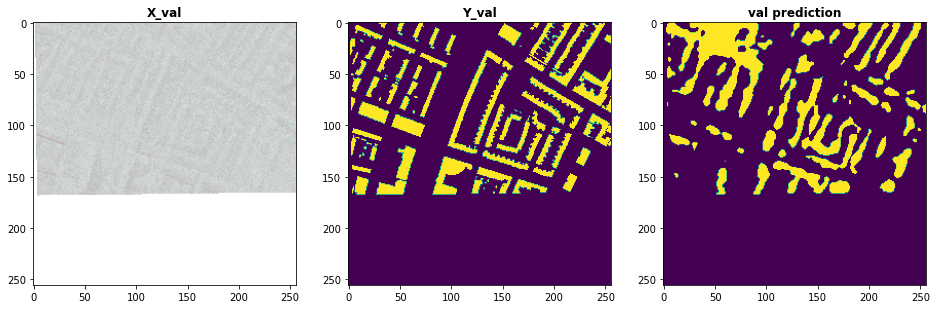

index: 22
test preds  set


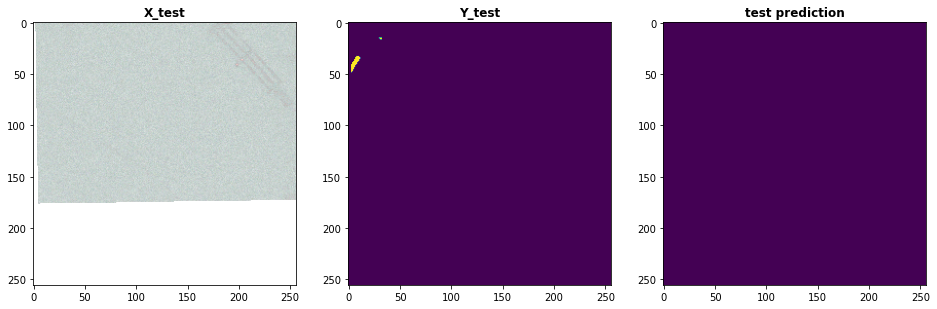

NameError: ignored

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

# Put a label over the output

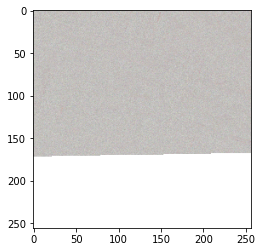

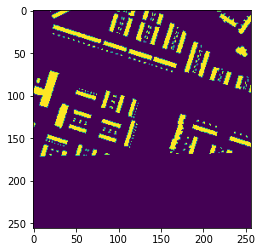

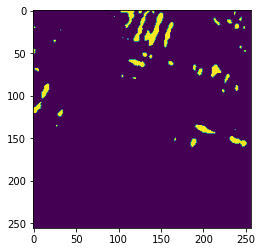

In [ ]:
idx = 20
show(reshape_as_raster(X_test[idx]))
show(reshape_as_raster(Y_test[idx]))
show(reshape_as_raster(preds_test_t[idx]))

In [ ]:
import skimage

In [ ]:
regionlabels, regioncount = skimage.measure.label(preds_test_t[idx], background=0, connectivity=1, return_num=True)
regionproperties = skimage.measure.regionprops(regionlabels)

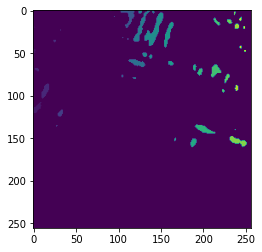

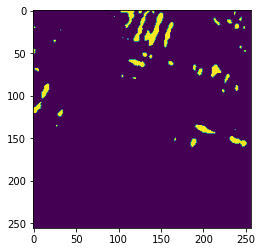

In [ ]:
show(reshape_as_raster(regionlabels))
show(reshape_as_raster(preds_test_t[idx]))

In [ ]:
regionlabels, regioncount = skimage.measure.label(Y_test[idx], background=0, connectivity=1, return_num=True)
regionproperties = skimage.measure.regionprops(regionlabels)

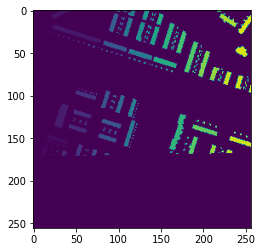

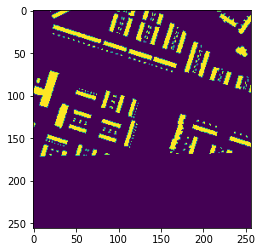

In [ ]:
show(reshape_as_raster(regionlabels))
show(reshape_as_raster(Y_test[idx]))

In [ ]:

! conda install -c conda-forge rtree gdal=2.4.1

/bin/bash: conda: command not found


In [ ]:
! pip install GDAL
! apt install python3-rtree
! pip install Shapely
! pip install geopandas


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
     |████████████████████████████████| 962kB 2.8MB/s 
  Using cached https://files.pythonhosted.org/packages/e5/c3/071e080230ac4b6c64f1a2e2f9161c9737a2bc7b683d2c90b024825000c0/pyproj-2.6.1.post1-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/20/4e63bc5c6e62df889297b382c3ccd4a7a488b00946aaaf81a118158c6f09/Fiona-1.8.13.post1-cp36-cp36m-manylinux1_x86_64.whl


In [ ]:
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

!pip install rasterio
!pip install geopandas
!pip install shapely
!pip install solaris

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ubuntugis-unstable/ubuntu bionic InRelease
Reading package lists... Done
Hit:1 http://secur

In [ ]:
! pip install solaris
# import solaris as sol

  Using cached https://files.pythonhosted.org/packages/a2/43/0cd758fa2aecd1f0d9206e71f17c498f40087b0077b100088d6ea1a14a22/solaris-0.2.2-py3-none-any.whl
     |████████████████████████████████| 133kB 2.9MB/s 
  Using cached https://files.pythonhosted.org/packages/f6/c4/a1e6ac237b5a27874b01900987d902fe83cc469ebdb09eb72a68c4329e78/albumentations-0.4.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/77/63/a9fa76de8dffe7455304c4ed635be4aa9c0bacef6e0633d87d5f54530c5c/tensorflow-1.13.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/51/bd/23c926cd341ea6b7dd0b2a00aba99ae0f828be89d72b2190f27c11d4b7fb/requests-2.22.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/56/6f/f1e91001d5ad9fa9bed65875152f5a1c7955c5763168cae309546e6e9fda/Rtree-0.9.4.tar.gz
  Using cached https://files.pythonhosted.org/packages/30/f9/ca554066837183727a645bd9f064213322c0e811fba1fb9c6fd38dafd8ca/GDAL-3.1.2.tar.gz
ERROR: Command errored out wi

In [ ]:
vectordata = sol.vector.mask.mask_to_poly_geojson(
    regionlabels,
    output_path=PATH_DATA/'output',
    output_type='csv',
    bg_threshold=128,
    do_transform=False,
    simplify=True
)

NameError: ignored